In [1]:
import numpy as np
import pandas as pd
import collections
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import sklearn as sk
from sklearn import metrics
from scipy import stats
import random
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, Flatten, GlobalAveragePooling1D, LSTM, Conv1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


In [2]:
print(tf.config.list_physical_devices('GPU'))
print(tf. __version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.5.0
Num GPUs Available:  1


In [3]:
def dictionary_word2vec(filename):
    di_word2vec = {}
    fasta_file = filename
    seq_list = []
    for (index,seq_record) in enumerate(SeqIO.parse(fasta_file, "fasta")):
        seq_list.append(str(seq_record.seq))
    arr = np.array(seq_list)
    # print(AAs.map(lambda x :list (x)))
    w2v_model = Word2Vec(arr, vector_size = 20)
    for idx , key in enumerate(w2v_model.wv.key_to_index):
        di_word2vec[key] = list(w2v_model.wv[key])
    # di_word2vec = list(w2v_model.wv.index_to_key)
    return di_word2vec

def dictionary_substitution_matrix_features(filename):
    AAs = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
    di_sub_mat_feat = {}
    for line in open(filename):
        if (line[0] in AAs):
            feats = line.split()[1:21] #keep only the first 20 corresponding the "common 20 AAs"
            feats = list(map(np.float32, feats))
            # print(feats)
            di_sub_mat_feat[line[0]] = feats
    return di_sub_mat_feat

def dictionary_one_hot():
    AAs = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
    di_one_hot = {}
    for (i,aa) in enumerate(AAs):
        di_one_hot[aa] = np.zeros((len(AAs)), dtype = np.float32)
        di_one_hot[aa][i] = 1.0
    return di_one_hot

def AAindex():
    filename = "AAindex.txt"
    AAs = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
    with open(filename) as f:
        records = f.readlines()[1:]
    AAindex = []
    AA_encoding = {}
    for i in records:
        AAindex.append(i.rstrip().split()[1:] if i.rstrip() != '' else None)
    for i in range(20):
        AA_encoding[AAs[i]] = [item[i] for item in AAindex]
    return AA_encoding

zscale = {
'A': [0.24,  -2.32,  0.60, -0.14,  1.30], # A
'C': [0.84,  -1.67,  3.71,  0.18, -2.65], # C
'D': [3.98,   0.93,  1.93, -2.46,  0.75], # D
'E': [3.11,   0.26, -0.11, -0.34, -0.25], # E
'F': [-4.22,  1.94,  1.06,  0.54, -0.62], # F
'G': [2.05,  -4.06,  0.36, -0.82, -0.38], # G
'H': [2.47,   1.95,  0.26,  3.90,  0.09], # H
'I': [-3.89, -1.73, -1.71, -0.84,  0.26], # I
'K': [2.29,   0.89, -2.49,  1.49,  0.31], # K
'L': [-4.28, -1.30, -1.49, -0.72,  0.84], # L
'M': [-2.85, -0.22,  0.47,  1.94, -0.98], # M
'N': [3.05,   1.62,  1.04, -1.15,  1.61], # N
'P': [-1.66,  0.27,  1.84,  0.70,  2.00], # P
'Q': [1.75,   0.50, -1.44, -1.34,  0.66], # Q
'R': [3.52,   2.50, -3.50,  1.99, -0.17], # R
'S': [2.39,  -1.07,  1.15, -1.39,  0.67], # S
'T': [0.75,  -2.18, -1.12, -1.46, -0.40], # T
'V': [-2.59, -2.64, -1.54, -0.85, -0.02], # V
'W': [-4.36,  3.94,  0.59,  3.44, -1.59], # W
'Y': [-2.54,  2.44,  0.43,  0.04, -1.47], # Y
}
def seq_to_embedding(seq_list,output_vector,AA_len):
    output_list = list()
    for seq in seq_list:
        output_array = np.zeros((AA_len,len(output_vector['A'])))
        for (index , aa) in enumerate(seq):
            output_array[index,:] = output_vector[aa]
        output_list.append(output_array)
    return np.array(output_list)

def evaluate(y_pred, y_test):
    MSE =  metrics.mean_squared_error(y_test,y_pred)
    MAE = metrics.mean_absolute_error(y_test,y_pred)
    R2 = metrics.r2_score(y_test,y_pred)
    PCC = stats.pearsonr(y_test,y_pred)
    print('Model Performance')
    print('MSE: {:0.3f}.'.format(MSE))
    print('MAE = {:0.3f}.'.format(MAE))
    print('R2 = {:0.3f}.'.format(R2))
    print('PCC = {:0.3f}.'.format(PCC[0]))
    
    return PCC[0]

def train_test_val_DL(train,test,val):
    train_x = train['SEQUENCE']
    train_y = train['NEW-CONCENTRATION']
    test_x = test['SEQUENCE']
    test_y = test['NEW-CONCENTRATION']
    val_x = val['SEQUENCE']
    val_y = val['NEW-CONCENTRATION']
    return train_x,test_x,val_x,train_y,test_y,val_y

def combine_features(X1,X2):
    combine_list = list()
    for i in range(len(X1)):
        combine_list.append(np.hstack((X1[i],X2[i])))
    return np.array(combine_list)

def save_model_history(model,history,model_name):
    model.save('{}.h5'.format(model_name))
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = '{}_history.json.'.format(model_name) 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)    

def Genomesequence_concat(Feature_array,Genome_array):
    # add an extra dimension to the array
    arr = np.expand_dims(Genome_array, axis=1)
    # replicate the data across the new dimension to match the desired shape 
    arr = np.tile(arr, (1, 1, 1))
    # define the desired shape after padding
    pad_shape = (Feature_array.shape[0], 1, Feature_array.shape[2])
    # pad the array with zeros along the last dimension
    arr_padded = np.pad(arr, [(0, 0), (0, 0), (0, pad_shape[2] - arr.shape[2])], mode='constant')
    # concat two array to one 
    concatenated_array = np.concatenate((Feature_array, arr_padded), axis=1)
    return concatenated_array

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res/(ss_tot + K.epsilon())

In [4]:
One_hot_encoding = dictionary_one_hot()
BLOSUM62 = dictionary_substitution_matrix_features("BLOSUM62.txt")
AAindex = AAindex()
output_vector = {}
AAs = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
for aa in AAs:
    output_vector[aa] = np.concatenate((AAindex[aa], BLOSUM62[aa], One_hot_encoding[aa], zscale[aa]))

In [16]:
#New collection 
#EC 
# EC_train = pd.read_csv('New_collection/EC_X_train.csv')
# EC_test = pd.read_csv('New_collection/EC_X_test.csv')
# EC_val = pd.read_csv('New_collection/EC_X_val.csv')

# #SA 
# SA_train = pd.read_csv('New_collection/SA_X_train.csv')
# SA_test = pd.read_csv('New_collection/SA_X_test.csv')
# SA_val = pd.read_csv('New_collection/SA_X_val.csv')

# #PA 
# PA_train = pd.read_csv('New_collection/PA_X_train.csv')
# PA_test = pd.read_csv('New_collection/PA_X_test.csv')
# PA_val = pd.read_csv('New_collection/PA_X_val.csv')

# Three_concat_train = pd.concat([SA_train, EC_train, PA_train], axis=0)

In [18]:
#My paper's dataset
#EC - 40
EC_train = pd.read_csv('My_paper/EC_X_train_40.csv')
EC_test = pd.read_csv('My_paper/EC_X_test_40.csv')
EC_val = pd.read_csv('My_paper/EC_X_val_40.csv')

#SA - 40
SA_train = pd.read_csv('My_paper/SA_X_train_40.csv')
SA_test = pd.read_csv('My_paper/SA_X_test_40.csv')
SA_val = pd.read_csv('My_paper/SA_X_val_40.csv')

#PA - 40
PA_train = pd.read_csv('My_paper/PA_X_train_40.csv')
PA_test = pd.read_csv('My_paper/PA_X_test_40.csv')
PA_val = pd.read_csv('My_paper/PA_X_val_40.csv')

Three_concat_train = pd.concat([SA_train, EC_train, PA_train], axis=0)

In [19]:
SA_X_train, SA_X_test, SA_X_val, SA_y_train, SA_y_test, SA_y_val = train_test_val_DL(SA_train,SA_test,SA_val)
EC_X_train, EC_X_test, EC_X_val, EC_y_train, EC_y_test, EC_y_val = train_test_val_DL(EC_train,EC_test,EC_val)
PA_X_train, PA_X_test, PA_X_val, PA_y_train, PA_y_test, PA_y_val = train_test_val_DL(PA_train,PA_test,PA_val)

In [20]:
SA_X_train = seq_to_embedding(SA_X_train,output_vector,40)
SA_X_test = seq_to_embedding(SA_X_test,output_vector,40)
SA_X_val = seq_to_embedding(SA_X_val,output_vector,40)

EC_X_train = seq_to_embedding(EC_X_train,output_vector,40)
EC_X_test = seq_to_embedding(EC_X_test,output_vector,40)
EC_X_val = seq_to_embedding(EC_X_val,output_vector,40)

PA_X_train = seq_to_embedding(PA_X_train,output_vector,40)
PA_X_test = seq_to_embedding(PA_X_test,output_vector,40)
PA_X_val = seq_to_embedding(PA_X_val,output_vector,40)

In [14]:
#New collection
#T5XL embedding
#EC
# T5XL_EC_X_train = np.load('New_collection\T5XL_Embeddings\EC_X_TRAIN.npy')
# T5XL_EC_X_test = np.load('New_collection\T5XL_Embeddings\EC_X_TEST.npy')
# T5XL_EC_X_val = np.load('New_collection\T5XL_Embeddings\EC_X_VAL.npy')

# #SA
# T5XL_SA_X_train = np.load('New_collection\T5XL_Embeddings\SA_X_TRAIN.npy')
# T5XL_SA_X_test = np.load('New_collection\T5XL_Embeddings\SA_X_TEST.npy')
# T5XL_SA_X_val = np.load('New_collection\T5XL_Embeddings\SA_X_VAL.npy')

# #PA
# T5XL_PA_X_train = np.load('New_collection\T5XL_Embeddings\PA_X_TRAIN.npy')
# T5XL_PA_X_test = np.load('New_collection\T5XL_Embeddings\PA_X_TEST.npy')
# T5XL_PA_X_val = np.load('New_collection\T5XL_Embeddings\PA_X_VAL.npy')


In [21]:
#My paper's dataset
#EC
T5XL_EC_X_train = np.load('My_paper/T5XL_Embeddings_max_40\EC_X_TRAIN.npy')
T5XL_EC_X_test = np.load('My_paper/T5XL_Embeddings_max_40\EC_X_TEST.npy')
T5XL_EC_X_val = np.load('My_paper/T5XL_Embeddings_max_40\EC_X_VAL.npy')

#SA
T5XL_SA_X_train = np.load('My_paper/T5XL_Embeddings_max_40\SA_X_TRAIN.npy')
T5XL_SA_X_test = np.load('My_paper/T5XL_Embeddings_max_40\SA_X_TEST.npy')
T5XL_SA_X_val = np.load('My_paper/T5XL_Embeddings_max_40\SA_X_VAL.npy')

#PA
T5XL_PA_X_train = np.load('My_paper/T5XL_Embeddings_max_40\PA_X_TRAIN.npy')
T5XL_PA_X_test = np.load('My_paper/T5XL_Embeddings_max_40\PA_X_TEST.npy')
T5XL_PA_X_val = np.load('My_paper/T5XL_Embeddings_max_40\PA_X_VAL.npy')


In [17]:
#New collection
#EC
# T5XL_EC_X_train_GS = Genomesequence_concat(T5XL_EC_X_train,EC_train.iloc[:,254:])
# T5XL_EC_X_test_GS = Genomesequence_concat(T5XL_EC_X_test,EC_test.iloc[:,254:])
# T5XL_EC_X_val_GS = Genomesequence_concat(T5XL_EC_X_val,EC_val.iloc[:,254:])

# #SA
# T5XL_SA_X_train_GS = Genomesequence_concat(T5XL_SA_X_train,SA_train.iloc[:,254:])
# T5XL_SA_X_test_GS = Genomesequence_concat(T5XL_SA_X_test,SA_test.iloc[:,254:])
# T5XL_SA_X_val_GS = Genomesequence_concat(T5XL_SA_X_val,SA_val.iloc[:,254:])

# #PA
# T5XL_PA_X_train_GS = Genomesequence_concat(T5XL_PA_X_train,PA_train.iloc[:,254:])
# T5XL_PA_X_test_GS = Genomesequence_concat(T5XL_PA_X_test,PA_test.iloc[:,254:])
# T5XL_PA_X_val_GS = Genomesequence_concat(T5XL_PA_X_val,PA_val.iloc[:,254:])


In [22]:
#My paper's dataset
#EC
T5XL_EC_X_train_GS = Genomesequence_concat(T5XL_EC_X_train,EC_train.iloc[:,250:-12])
T5XL_EC_X_test_GS = Genomesequence_concat(T5XL_EC_X_test,EC_test.iloc[:,250:-12])
T5XL_EC_X_val_GS = Genomesequence_concat(T5XL_EC_X_val,EC_val.iloc[:,250:-12])

#SA
T5XL_SA_X_train_GS = Genomesequence_concat(T5XL_SA_X_train,SA_train.iloc[:,250:-12])
T5XL_SA_X_test_GS = Genomesequence_concat(T5XL_SA_X_test,SA_test.iloc[:,250:-12])
T5XL_SA_X_val_GS = Genomesequence_concat(T5XL_SA_X_val,SA_val.iloc[:,250:-12])

#PA
T5XL_PA_X_train_GS = Genomesequence_concat(T5XL_PA_X_train,PA_train.iloc[:,250:-12])
T5XL_PA_X_test_GS = Genomesequence_concat(T5XL_PA_X_test,PA_test.iloc[:,250:-12])
T5XL_PA_X_val_GS = Genomesequence_concat(T5XL_PA_X_val,PA_val.iloc[:,250:-12])

In [23]:
# With Genome sequence
T5XL_three_train_concat = np.concatenate([T5XL_EC_X_train_GS,T5XL_SA_X_train_GS,T5XL_PA_X_train_GS])
T5XL_three_test_concat = np.concatenate([T5XL_EC_X_test_GS,T5XL_SA_X_test_GS,T5XL_PA_X_test_GS])
T5XL_three_val_concat = np.concatenate([T5XL_EC_X_val_GS,T5XL_SA_X_val_GS,T5XL_PA_X_val_GS])

# Concat
Three_train = pd.concat([EC_train,SA_train,PA_train])
Three_test = pd.concat([EC_test,SA_test,PA_test])
Three_val = pd.concat([EC_val,SA_val,PA_val])

# Model with AMPs sequence-based featues

In [24]:
def Bilstm_model(X,y,X_val,y_val,unit = 512, lr=0.0005, batch_size = 20):
    tf.random.set_seed(150)
    np.random.seed(150)
    random.seed(150)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    model = tf.keras.models.Sequential()
    input_shape = (X.shape[1],X.shape[2])
    forward_layer = tf.keras.layers.LSTM(unit,input_shape = input_shape)
    backward_layer = tf.keras.layers.LSTM(unit,go_backwards=True, input_shape = input_shape)
    bilstm = tf.keras.layers.Bidirectional(forward_layer,backward_layer = backward_layer , input_shape = input_shape)

    model.add(bilstm)
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mean_squared_error',"mean_absolute_error","cosine_similarity"])
    history = model.fit(X , y, epochs = 1000, batch_size = batch_size, callbacks=[es_callback],validation_data=(X_val,y_val))
    return model,history

In [25]:
def CNN_model(X,y,X_val,y_val,conv1 = 64, conv2 = 128, k= 7, p= 5, lr=0.0005, batch_size = 20):
    tf.random.set_seed(150)
    np.random.seed(150)
    random.seed(150)
    model = tf.keras.models.Sequential()
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    input_shape = (np.array(X).shape[1],np.array(X).shape[2],1)
    model.add(tf.keras.layers.Conv2D(conv1, kernel_size=(k, k),padding='same',activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(p, p)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(conv2, (k, k), activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(p, p)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.summary()
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mean_squared_error',"mean_absolute_error"])
    history = model.fit(np.array(X) , y, epochs = 1000, batch_size = batch_size, callbacks=[es_callback],validation_data=(X_val,y_val))
    return model,history

In [26]:
def transformer_model(X , E_layer = 2, D_layer = 2,d_model = 1024, n_head = 16, d_k = 64, d_v = 64, 
                      d_ff = 512, dropout_rate=0.1):
    # Input layer
    input_shape = (X.shape[1],X.shape[2])
    d_model = X.shape[2]
    inputs = Input(shape=(input_shape))
    
    
    # Encoder stack
    encoder_output = inputs
    for _ in range(E_layer):  
        # Multi-Head Attention layer
        attn_output = MultiHeadAttention(
            num_heads=n_head, key_dim=d_k, value_dim=d_v, dropout=dropout_rate
        )(encoder_output, encoder_output)
        # Add and Norm
        attn_output = LayerNormalization(epsilon=1e-6)(encoder_output + attn_output)

        
        # Position-wise Feed-Forward layer
        ff_output = Conv1D(filters=d_ff, kernel_size=1, activation="relu")(attn_output)
        ff_output = Conv1D(filters=d_model, kernel_size=1)(ff_output)

        # Add and Norm
        encoder_output = LayerNormalization(epsilon=1e-6)(attn_output + ff_output)

    # Decoder stack
    decoder_output = encoder_output
    for _ in range(D_layer):  
        # Masked Multi-Head Attention layer
        attn_output = MultiHeadAttention(
            num_heads=n_head, key_dim=d_k, value_dim=d_v, dropout=dropout_rate)(decoder_output, decoder_output)
        # Add and Norm
        attn_output = LayerNormalization(epsilon=1e-6)(decoder_output + attn_output)

        # Multi-Head Attention layer (with encoder output)
        attn_output = MultiHeadAttention(
            num_heads=n_head, key_dim=d_k, value_dim=d_v, dropout=dropout_rate
        )(attn_output, encoder_output)
        # Add and Norm
        attn_output = LayerNormalization(epsilon=1e-6)(attn_output + attn_output)

        # Position-wise Feed-Forward layer
        ff_output = Conv1D(filters=d_ff, kernel_size=1, activation="relu")(attn_output)
        ff_output = Conv1D(filters=d_model, kernel_size=1)(ff_output)

        # Add and Norm
        decoder_output = LayerNormalization(epsilon=1e-6)(attn_output + ff_output)

    # Regressor layer
    FC = GlobalAveragePooling1D()(decoder_output)
    FC = Dense(128, activation='relu')(FC)
    FC = Dropout(rate=dropout_rate)(FC)
    FC = Dense(64, activation='relu')(FC)
    FC = Dropout(rate=dropout_rate)(FC)

    outputs = Dense(1, activation='linear')(FC)
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.summary()
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mean_squared_error',"mean_absolute_error"])
    
    return model

In [27]:
def bilstm_CNN_model(X,dropouts=0.2,k=7,p=5,l1=64,l2=128,bi_units = 512,n_heads = 8,k_dim = 32,units = 128):
    tf.random.set_seed(150)
    np.random.seed(150)
    random.seed(150)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    
    #CNN 
    input1_shape = (X.shape[1],X.shape[2],1)
    input1_layer = tf.keras.layers.Input(shape=input1_shape)
    x1 = tf.keras.layers.Conv2D(l1, kernel_size=(k, k),padding='same',activation='relu')(input1_layer)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(p, p))(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(l2, kernel_size=(k, k),padding='same',activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(p, p))(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)    
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(units, activation='relu')(x1)
    x1 = tf.keras.layers.Dropout(rate=dropouts)(x1)
    
    #Bilstm     
    input2_shape = (X.shape[1],X.shape[2])
    input2_layer = tf.keras.layers.Input(shape=input2_shape)
    forward_layer = tf.keras.layers.LSTM(bi_units)
    backward_layer = tf.keras.layers.LSTM(bi_units,go_backwards=True)
    bilstm = tf.keras.layers.Bidirectional(forward_layer,backward_layer = backward_layer, input_shape = input2_shape)
    x2 = bilstm(input2_layer)
    x2 = tf.keras.layers.Dense(units, activation='relu')(x2)
    x2 = tf.keras.layers.Dropout(rate=dropouts)(x2)
    
    # Cross-Attention
    cross_attention = tf.keras.layers.MultiHeadAttention(key_dim=k_dim, num_heads=n_heads, dropout=dropouts)
    x1 = tf.keras.layers.Reshape((1, units))(x1)
    x2 = tf.keras.layers.Reshape((1, units))(x2)
    x1_cross = cross_attention(x1, x2)
    x2_cross = cross_attention(x2, x1)

    # Concatenate cross-attention outputs with original outputs
    x1_concat = tf.keras.layers.Concatenate()([x1, x1_cross])
    x2_concat = tf.keras.layers.Concatenate()([x2, x2_cross])
    
    #Merged
    concatted = tf.keras.layers.Concatenate()([x1_concat, x2_concat])
#     FC = tf.keras.layers.BatchNormalization()(concatted)
    FC = Dense(128, activation='relu')(concatted)
    FC = Dropout(rate=dropouts)(FC)
    FC = Dense(64, activation='relu')(FC)
    FC = Dropout(rate=dropouts)(FC)
    FC = Flatten()(FC)
    output_layer = tf.keras.layers.Dense(1)(FC)    

    model = tf.keras.models.Model(inputs=[input1_layer,input2_layer], outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

    model.summary()
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mean_squared_error',"mean_absolute_error"])
    return model

# Model with AMPs sequence-based featues and Genome sequence-based feature

In [28]:
def CNN_wGS_model(X,y,X_val,y_val,batch_size = 20,k=5,p=3,l1=64,l2=128,dropouts=0.2,max_length=40,genome_seq=84):
    tf.random.set_seed(150)
    np.random.seed(150)
    random.seed(150)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    Embeddings_feature = X[:,:max_length,:]
    GenomeSequence_feature = X[:,max_length,:][:,:genome_seq]
    
    #CNN Embeddings
    input_shape1 = (Embeddings_feature.shape[1],Embeddings_feature.shape[2],1)
    input_layer1 = tf.keras.layers.Input(shape=input_shape1)
    x1 = tf.keras.layers.Conv2D(l1, kernel_size=(k, k),padding='same',activation='relu')(input_layer1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(p, p))(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(l2, kernel_size=(k, k),padding='same',activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(p, p))(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    
    #Genome feature
    input_shape2 = (GenomeSequence_feature.shape[1])
    input_layer2 = tf.keras.layers.Input(shape=input_shape2)
    x2 = tf.keras.layers.Dense(32,activation='relu')(input_layer2)
    x2 = tf.keras.layers.Dense(16,activation='relu')(x2)
    
    #Concat
    x3 = tf.keras.layers.Concatenate()([x1, x2])
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Dropout(rate=dropouts)(x3)
    x3 = tf.keras.layers.Dense(64, activation='relu')(x3)
    x3 = tf.keras.layers.Dense(32, activation='relu')(x3)
    x3 = tf.keras.layers.Dropout(rate=dropouts)(x3)
    output_layer = tf.keras.layers.Dense(1)(x3)
    
    model = tf.keras.models.Model(inputs=[input_layer1,input_layer2], outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.summary()
    Embeddings_feature_val = X_val[:,:max_length,:]
    GenomeSequence_feature_val = X_val[:,max_length,:][:,:genome_seq]
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mean_squared_error',"mean_absolute_error"])
    history = model.fit([Embeddings_feature,GenomeSequence_feature] , y, epochs = 1000, 
                        batch_size = batch_size, callbacks=[es_callback],
                        validation_data=([Embeddings_feature_val,GenomeSequence_feature_val],y_val))
    return model,history

In [29]:
def Bilstm_wGS_model(X,y,X_val,y_val,batch_size = 20,bi_units = 512,dropouts=0.2,max_length=40,genome_seq=84):
    tf.random.set_seed(150)
    np.random.seed(150)
    random.seed(150)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    Embeddings_feature = X[:,:max_length,:]
    GenomeSequence_feature = X[:,max_length,:][:,:genome_seq]
    
    #Bilstm Embeddings
    input_shape1 = (Embeddings_feature.shape[1],Embeddings_feature.shape[2])
    input_layer1 = tf.keras.layers.Input(shape=input_shape1)
    forward_layer = tf.keras.layers.LSTM(bi_units)
    backward_layer = tf.keras.layers.LSTM(bi_units,go_backwards=True)
    bilstm = tf.keras.layers.Bidirectional(forward_layer,backward_layer = backward_layer, input_shape = input_shape1)
    x1 = bilstm(input_layer1)
    
    #Genome feature
    input_shape2 = (GenomeSequence_feature.shape[1])
    input_layer2 = tf.keras.layers.Input(shape=input_shape2)
    x2 = tf.keras.layers.Dense(32,activation='relu')(input_layer2)
    x2 = tf.keras.layers.Dense(16,activation='relu')(x2)
    
    #Concat
    concatted = tf.keras.layers.Concatenate()([x1, x2])
    x3 = tf.keras.layers.BatchNormalization()(concatted)
    x3 = tf.keras.layers.Dropout(rate=dropouts)(x3)
    x3 = tf.keras.layers.Dense(64, activation='relu')(x3)
    x3 = tf.keras.layers.Dense(32, activation='relu')(x3)
    x3 = tf.keras.layers.Dropout(rate=dropouts)(x3)
    output_layer = tf.keras.layers.Dense(1)(x3)
    
    model = tf.keras.models.Model(inputs=[input_layer1,input_layer2], outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.summary()
    Embeddings_feature_val = X_val[:,:max_length,:]
    GenomeSequence_feature_val = X_val[:,max_length,:][:,:genome_seq]
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mean_squared_error',"mean_absolute_error"])
    history = model.fit([Embeddings_feature,GenomeSequence_feature] , y, epochs = 1000, 
                        batch_size = batch_size, callbacks=[es_callback],
                        validation_data=([Embeddings_feature_val,GenomeSequence_feature_val],y_val))
    return model,history

In [30]:
def transformer_wGS_model(X,y,X_val,y_val,batch_size = 20,E_layer = 2,D_layer = 2,
                          n_head = 16, d_k = 64, d_v = 64, d_ff = 512,
                          dropout_rate=0.1,max_length=40,genome_seq=84):
    # Input layer
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    Embeddings_feature = X[:,:max_length,:]
    GenomeSequence_feature = X[:,max_length,:][:,:genome_seq]
    
    input_shape1 = (Embeddings_feature.shape[1],Embeddings_feature.shape[2])
    input_layer1 = tf.keras.layers.Input(shape=input_shape1)
    d_model = Embeddings_feature.shape[2]
    # Encoder stack
    encoder_output = input_layer1
    for _ in range(E_layer):  
        # Multi-Head Attention layer
        attn_output = MultiHeadAttention(
            num_heads=n_head, key_dim=d_k, value_dim=d_v, dropout=dropout_rate
        )(encoder_output, encoder_output)
        # Add and Norm
        attn_output = LayerNormalization(epsilon=1e-6)(encoder_output + attn_output)

        
        # Position-wise Feed-Forward layer
        ff_output = Conv1D(filters=d_ff, kernel_size=1, activation="relu")(attn_output)
        ff_output = Conv1D(filters=d_model, kernel_size=1)(ff_output)

        # Add and Norm
        encoder_output = LayerNormalization(epsilon=1e-6)(attn_output + ff_output)

    # Decoder stack
    decoder_output = encoder_output
    for _ in range(D_layer):  
        # Masked Multi-Head Attention layer
        attn_output = MultiHeadAttention(
            num_heads=n_head, key_dim=d_k, value_dim=d_v, dropout=dropout_rate)(decoder_output, decoder_output)
        # Add and Norm
        attn_output = LayerNormalization(epsilon=1e-6)(decoder_output + attn_output)

        # Multi-Head Attention layer (with encoder output)
        attn_output = MultiHeadAttention(
            num_heads=n_head, key_dim=d_k, value_dim=d_v, dropout=dropout_rate
        )(attn_output, encoder_output)
        # Add and Norm
        attn_output = LayerNormalization(epsilon=1e-6)(attn_output + attn_output)

        # Position-wise Feed-Forward layer
        ff_output = Conv1D(filters=d_ff, kernel_size=1, activation="relu")(attn_output)
        ff_output = Conv1D(filters=d_model, kernel_size=1)(ff_output)

        # Add and Norm
        decoder_output = LayerNormalization(epsilon=1e-6)(attn_output + ff_output)

    #Genome feature
    input_shape2 = (GenomeSequence_feature.shape[1])
    input_layer2 = tf.keras.layers.Input(shape=input_shape2)
    x2 = tf.keras.layers.Dense(32,activation='relu')(input_layer2)
    x2 = tf.keras.layers.Dense(16,activation='relu')(x2)
    
    # Regressor layer
    FC = GlobalAveragePooling1D()(decoder_output)
    FC = tf.keras.layers.Concatenate()([FC, x2])
    FC = tf.keras.layers.BatchNormalization()(FC)
    FC = Dropout(rate=dropout_rate)(FC)
    FC = Dense(128, activation='relu')(FC)
    FC = Dense(64, activation='relu')(FC)
    FC = tf.keras.layers.BatchNormalization()(FC)
    FC = Dropout(rate=dropout_rate)(FC)

    outputs = Dense(1, activation='linear')(FC)
    # Create the model
    model = Model(inputs=[input_layer1,input_layer2], outputs=outputs)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.summary()
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=[r_squared,'mean_squared_error',"mean_absolute_error"])
    Embeddings_feature_val = X_val[:,:max_length,:]
    GenomeSequence_feature_val = X_val[:,max_length,:][:,:genome_seq]
    history = model.fit([Embeddings_feature,GenomeSequence_feature] , y, epochs = 1000, 
                        batch_size = batch_size, callbacks=[es_callback],
                        validation_data=([Embeddings_feature_val,GenomeSequence_feature_val],y_val))
    
    return model,history

In [31]:
def bilstm_CNN_wGS_model(X,y,X_val,y_val,batch_size = 20,
                     dropouts=0.2,k=7,p=5,l1=64,l2=128,bi_units = 512,
                     n_heads = 8,k_dim = 32,units = 128,max_length=40,genome_seq=84):
    tf.random.set_seed(150)
    np.random.seed(150)
    random.seed(150)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    Embeddings_feature = X[:,:max_length,:]
    GenomeSequence_feature = X[:,max_length,:][:,:genome_seq]
    
    #CNN 
    input1_shape = (X.shape[1]-1,X.shape[2],1)
    input1_layer = tf.keras.layers.Input(shape=input1_shape)
    x1 = tf.keras.layers.Conv2D(l1, kernel_size=(k, k),padding='same',activation='relu')(input1_layer)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(p, p))(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(l2, kernel_size=(k, k),padding='same',activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(p, p))(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)    
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    x1 = tf.keras.layers.Dense(units, activation='relu')(x1)
    x1 = tf.keras.layers.Dropout(rate=dropouts)(x1)
    #Bilstm     
    input2_shape = (X.shape[1]-1,X.shape[2])
    input2_layer = tf.keras.layers.Input(shape=input2_shape)
    forward_layer = tf.keras.layers.LSTM(bi_units)
    backward_layer = tf.keras.layers.LSTM(bi_units,go_backwards=True)
    bilstm = tf.keras.layers.Bidirectional(forward_layer,backward_layer = backward_layer, input_shape = input2_shape)
    x2 = bilstm(input2_layer)
    x2 = tf.keras.layers.Dense(units, activation='relu')(x2)
    x2 = tf.keras.layers.Dropout(rate=dropouts)(x2)
    
    # Cross-Attention
    cross_attention = tf.keras.layers.MultiHeadAttention(key_dim=k_dim, num_heads=n_heads, dropout=dropouts)
    x1 = tf.keras.layers.Reshape((1, units))(x1)
    x2 = tf.keras.layers.Reshape((1, units))(x2)
    x1_cross = cross_attention(x1, x2)
    x2_cross = cross_attention(x2, x1)

    # Concatenate cross-attention outputs with original outputs
    x1_concat = tf.keras.layers.Concatenate()([x1, x1_cross])
    x2_concat = tf.keras.layers.Concatenate()([x2, x2_cross])
    
    #Genome feature
    input_shape3 = (GenomeSequence_feature.shape[1])
    input_layer3 = tf.keras.layers.Input(shape=input_shape3)
    x3 = tf.keras.layers.Dense(32,activation='relu')(input_layer3)
    x3 = tf.keras.layers.Dense(16,activation='relu')(x3)
    
    #Merged
    FC = tf.keras.layers.Concatenate()([x1_concat, x2_concat])
    FC = GlobalAveragePooling1D()(FC)
    FC = tf.keras.layers.Concatenate()([FC, x3])
    FC = tf.keras.layers.BatchNormalization()(FC)
    FC = Dropout(rate=dropouts)(FC)
    FC = Dense(64, activation='relu')(FC)
    FC = tf.keras.layers.BatchNormalization()(FC)
    FC = Dropout(rate=dropouts)(FC)
    FC = Dense(32, activation='relu')(FC)

    output_layer = tf.keras.layers.Dense(1, activation='linear')(FC)
    
    X_1 = Embeddings_feature.reshape(Embeddings_feature.shape[0],Embeddings_feature.shape[1],Embeddings_feature.shape[2],1)
    X_2 = Embeddings_feature
    X_3 = GenomeSequence_feature
    model = tf.keras.models.Model(inputs=[input1_layer,input2_layer,input_layer3], outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    Embeddings_feature_val = X_val[:,:max_length,:]
    GenomeSequence_feature_val = X_val[:,max_length,:][:,:genome_seq]
    X_val_1 = Embeddings_feature_val.reshape(Embeddings_feature_val.shape[0],Embeddings_feature_val.shape[1],Embeddings_feature_val.shape[2],1)
    X_val_2 = Embeddings_feature_val
    X_val_3 = GenomeSequence_feature_val
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=[r_squared,'mean_squared_error',"mean_absolute_error"])
    model.summary()
    history = model.fit([X_1,X_2,X_3] , y, epochs = 1000, 
                        batch_size = batch_size, callbacks=[es_callback],
                        validation_data=([X_val_1,X_val_2,X_val_3],y_val))
    return model,history

# Model Training

In [38]:
# only with sequence-based features
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
# BiLSTM
T5_EC_Bilstm,T5_EC_Bilstm_history = Bilstm_model(T5XL_EC_X_train,EC_train['NEW-CONCENTRATION'],
                                                 T5XL_EC_X_val,EC_val['NEW-CONCENTRATION'],
                                                 batch_size = 40)
# CNN
EC_X = T5XL_EC_X_train.reshape(T5XL_EC_X_train.shape[0],T5XL_EC_X_train.shape[1],T5XL_EC_X_train.shape[2],1)
EC_Y = EC_train['NEW-CONCENTRATION']
EC_val_x = T5XL_EC_X_val.reshape(T5XL_EC_X_val.shape[0],T5XL_EC_X_val.shape[1],T5XL_EC_X_val.shape[2],1)
EC_val_y = EC_val['NEW-CONCENTRATION']
T5_EC_CNN, T5_EC_CNN_history = CNN_model(EC_X,EC_Y,EC_val_x,EC_val_y,batch_size = 40)
# Transformer
EC_transformer = transformer_model(T5XL_EC_X_train,E_layer = 2, D_layer = 2, n_head = 1,d_k = 8, d_v = 8, d_ff = 32, dropout_rate = 0.5)
EC_Transformer_history = EC_transformer.fit(T5XL_EC_X_train, EC_train['NEW-CONCENTRATION'], epochs = 1000, batch_size = 40, 
                                   callbacks=[es_callback] , validation_data=(T5XL_EC_X_val,EC_val['NEW-CONCENTRATION']))
# Multi-Branch model
EC_bilstm_CNN = bilstm_CNN_model(T5XL_EC_X_train, dropouts=0.1,k=7,p=5,l1=64,l2=128,bi_units = 512,n_heads = 2,k_dim = 64,units = 64)
EC_bilstm_CNN_history = EC_bilstm_CNN.fit([T5XL_EC_X_train.reshape(T5XL_EC_X_train.shape[0],T5XL_EC_X_train.shape[1],T5XL_EC_X_train.shape[2],1),
                                                 T5XL_EC_X_train],EC_train['NEW-CONCENTRATION'],
                                                epochs = 1000, batch_size = 40, callbacks=[es_callback],
                                                validation_data=([T5XL_EC_X_val.reshape(T5XL_EC_X_val.shape[0],T5XL_EC_X_val.shape[1],T5XL_EC_X_val.shape[2],1),
                                                T5XL_EC_X_val],EC_val['NEW-CONCENTRATION']))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dense_57 (Dense)             (None, 64)                65600     
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_35 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 33        
Total params: 6,363,265
Trainable params: 6,363,265
Non-trainable params: 0
____________________________________________

258/258 [==============================] - 4s 16ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1439 - cosine_similarity: 0.9355 - val_loss: 0.4183 - val_mean_squared_error: 0.4183 - val_mean_absolute_error: 0.4672 - val_cosine_similarity: 0.8559
Epoch 54/1000
258/258 [==============================] - 4s 16ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1487 - cosine_similarity: 0.9285 - val_loss: 0.4007 - val_mean_squared_error: 0.4007 - val_mean_absolute_error: 0.4581 - val_cosine_similarity: 0.8513
Epoch 55/1000
258/258 [==============================] - 4s 16ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1506 - cosine_similarity: 0.9297 - val_loss: 0.4136 - val_mean_squared_error: 0.4136 - val_mean_absolute_error: 0.4686 - val_cosine_similarity: 0.8497
Epoch 56/1000
258/258 [==============================] - 4s 16ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1464 

258/258 [==============================] - 8s 32ms/step - loss: 0.1238 - mean_squared_error: 0.1238 - mean_absolute_error: 0.2671 - val_loss: 0.4548 - val_mean_squared_error: 0.4548 - val_mean_absolute_error: 0.5188
Epoch 24/1000
258/258 [==============================] - 8s 32ms/step - loss: 0.1176 - mean_squared_error: 0.1176 - mean_absolute_error: 0.2602 - val_loss: 0.4057 - val_mean_squared_error: 0.4057 - val_mean_absolute_error: 0.4821
Epoch 25/1000
258/258 [==============================] - 8s 32ms/step - loss: 0.1123 - mean_squared_error: 0.1123 - mean_absolute_error: 0.2517 - val_loss: 0.4385 - val_mean_squared_error: 0.4385 - val_mean_absolute_error: 0.5065
Epoch 26/1000
258/258 [==============================] - 8s 32ms/step - loss: 0.1069 - mean_squared_error: 0.1069 - mean_absolute_error: 0.2464 - val_loss: 0.4085 - val_mean_squared_error: 0.4085 - val_mean_absolute_error: 0.4802
Epoch 27/1000
258/258 [==============================] - 8s 32ms/step - loss: 0.1016 - mean_sq

Epoch 59/1000
258/258 [==============================] - 8s 32ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1547 - val_loss: 0.4112 - val_mean_squared_error: 0.4112 - val_mean_absolute_error: 0.4807
Epoch 60/1000
258/258 [==============================] - 8s 32ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1560 - val_loss: 0.4370 - val_mean_squared_error: 0.4370 - val_mean_absolute_error: 0.5014
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 40, 1024)]   0                                            
__________________________________________________________________________________________________
multi_head_attention_22 (MultiH (None, 40, 1024)     33816       input_20[0][0]                   
                           

Epoch 1/1000
26/26 [==============================] - 6s 124ms/step - loss: 2.5483 - mean_squared_error: 2.5483 - mean_absolute_error: 1.1376 - val_loss: 1.0020 - val_mean_squared_error: 1.0020 - val_mean_absolute_error: 0.8008
Epoch 2/1000
26/26 [==============================] - 3s 108ms/step - loss: 0.9276 - mean_squared_error: 0.9276 - mean_absolute_error: 0.7678 - val_loss: 0.8753 - val_mean_squared_error: 0.8753 - val_mean_absolute_error: 0.7442
Epoch 3/1000
26/26 [==============================] - 3s 108ms/step - loss: 0.9017 - mean_squared_error: 0.9017 - mean_absolute_error: 0.7596 - val_loss: 0.9561 - val_mean_squared_error: 0.9561 - val_mean_absolute_error: 0.7798
Epoch 4/1000
26/26 [==============================] - 3s 108ms/step - loss: 0.7683 - mean_squared_error: 0.7683 - mean_absolute_error: 0.6994 - val_loss: 0.7463 - val_mean_squared_error: 0.7463 - val_mean_absolute_error: 0.6917
Epoch 5/1000
26/26 [==============================] - 3s 108ms/step - loss: 0.7418 - mea

Epoch 37/1000
26/26 [==============================] - 3s 108ms/step - loss: 0.7103 - mean_squared_error: 0.7103 - mean_absolute_error: 0.6752 - val_loss: 0.7457 - val_mean_squared_error: 0.7457 - val_mean_absolute_error: 0.6920
Epoch 38/1000
26/26 [==============================] - 3s 107ms/step - loss: 0.7107 - mean_squared_error: 0.7107 - mean_absolute_error: 0.6771 - val_loss: 0.7481 - val_mean_squared_error: 0.7481 - val_mean_absolute_error: 0.6921
Epoch 39/1000
26/26 [==============================] - 3s 108ms/step - loss: 0.7114 - mean_squared_error: 0.7114 - mean_absolute_error: 0.6784 - val_loss: 0.7462 - val_mean_squared_error: 0.7462 - val_mean_absolute_error: 0.6918
Epoch 40/1000
26/26 [==============================] - 3s 108ms/step - loss: 0.7113 - mean_squared_error: 0.7113 - mean_absolute_error: 0.6787 - val_loss: 0.7465 - val_mean_squared_error: 0.7465 - val_mean_absolute_error: 0.6918
Epoch 41/1000
26/26 [==============================] - 3s 108ms/step - loss: 0.7073 

Epoch 1/1000
26/26 [==============================] - 12s 344ms/step - loss: 11.1103 - mean_squared_error: 11.1103 - mean_absolute_error: 1.7365 - val_loss: 1.5080 - val_mean_squared_error: 1.5080 - val_mean_absolute_error: 1.0167
Epoch 2/1000
26/26 [==============================] - 7s 276ms/step - loss: 0.8343 - mean_squared_error: 0.8343 - mean_absolute_error: 0.7306 - val_loss: 0.8067 - val_mean_squared_error: 0.8067 - val_mean_absolute_error: 0.7144
Epoch 3/1000
26/26 [==============================] - 7s 275ms/step - loss: 0.7277 - mean_squared_error: 0.7277 - mean_absolute_error: 0.6867 - val_loss: 0.7505 - val_mean_squared_error: 0.7505 - val_mean_absolute_error: 0.6906
Epoch 4/1000
26/26 [==============================] - 7s 275ms/step - loss: 0.6853 - mean_squared_error: 0.6853 - mean_absolute_error: 0.6664 - val_loss: 0.8125 - val_mean_squared_error: 0.8125 - val_mean_absolute_error: 0.7156
Epoch 5/1000
26/26 [==============================] - 7s 276ms/step - loss: 0.6787 - 

Epoch 37/1000
26/26 [==============================] - 7s 276ms/step - loss: 0.2616 - mean_squared_error: 0.2616 - mean_absolute_error: 0.3935 - val_loss: 0.4656 - val_mean_squared_error: 0.4656 - val_mean_absolute_error: 0.5260
Epoch 38/1000
26/26 [==============================] - 7s 276ms/step - loss: 0.2677 - mean_squared_error: 0.2677 - mean_absolute_error: 0.4002 - val_loss: 0.5065 - val_mean_squared_error: 0.5065 - val_mean_absolute_error: 0.5549
Epoch 39/1000
26/26 [==============================] - 7s 275ms/step - loss: 0.2855 - mean_squared_error: 0.2855 - mean_absolute_error: 0.4170 - val_loss: 0.4833 - val_mean_squared_error: 0.4833 - val_mean_absolute_error: 0.5343
Epoch 40/1000
26/26 [==============================] - 7s 276ms/step - loss: 0.2464 - mean_squared_error: 0.2464 - mean_absolute_error: 0.3802 - val_loss: 0.4712 - val_mean_squared_error: 0.4712 - val_mean_absolute_error: 0.5261
Epoch 41/1000
26/26 [==============================] - 7s 275ms/step - loss: 0.2392 

In [42]:
# with sequence-based and genome-based features
#BiLSTM
Three_BiLSTM,Three_BiLSTM_history = Bilstm_wGS_model(T5XL_three_train_concat,Three_train['NEW-CONCENTRATION'],
                                                     T5XL_three_val_concat,Three_val['NEW-CONCENTRATION'],
                                                     batch_size = 40,bi_units = 512,dropouts=0.1)
# #CNN
Three_CNN,Three_CNN_history = CNN_wGS_model(T5XL_three_train_concat,Three_train['NEW-CONCENTRATION'],
                                            T5XL_three_val_concat,Three_val['NEW-CONCENTRATION'],
                                            batch_size = 40,k=7,p=5,l1=64,l2=128,dropouts=0.1)
#Transformer
Three_Transformer,Three_Transformer_history = transformer_wGS_model(T5XL_three_train_concat,Three_train['NEW-CONCENTRATION'],
                                                                    T5XL_three_val_concat,Three_val['NEW-CONCENTRATION'],
                                    batch_size = 40,E_layer = 1,D_layer = 1,n_head = 32, d_k = 128, d_v = 128, d_ff = 512
                                    ,dropout_rate=0.2)
#Multi-Branch model
Three_MB,Three_MB_history = bilstm_CNN_wGS_model(T5XL_three_train_concat,Three_train['NEW-CONCENTRATION'],
                                                 T5XL_three_val_concat,Three_val['NEW-CONCENTRATION'],
                    batch_size = 40,dropouts=0.1,k=7,p=5,l1=64,l2=128,bi_units = 512,
                    n_heads = 8, k_dim = 32, units = 256)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 84)]         0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 40, 1024)]   0                                            
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 32)           2720        input_33[0][0]                   
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 1024)         6295552     input_32[0][0]                   
___________________________________________________________________________________________

Epoch 24/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.1471 - mean_squared_error: 0.1471 - mean_absolute_error: 0.2892 - val_loss: 0.3240 - val_mean_squared_error: 0.3240 - val_mean_absolute_error: 0.4269
Epoch 25/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.1410 - mean_squared_error: 0.1410 - mean_absolute_error: 0.2826 - val_loss: 0.3168 - val_mean_squared_error: 0.3168 - val_mean_absolute_error: 0.4135
Epoch 26/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.1387 - mean_squared_error: 0.1387 - mean_absolute_error: 0.2805 - val_loss: 0.3078 - val_mean_squared_error: 0.3078 - val_mean_absolute_error: 0.4095
Epoch 27/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.1334 - mean_squared_error: 0.1334 - mean_absolute_error: 0.2733 - val_loss: 0.3232 - val_mean_squared_error: 0.3232 - val_mean_absolute_error: 0.4268
Epoch 28/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.

Epoch 60/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - mean_absolute_error: 0.1776 - val_loss: 0.3072 - val_mean_squared_error: 0.3072 - val_mean_absolute_error: 0.3947
Epoch 61/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1811 - val_loss: 0.3060 - val_mean_squared_error: 0.3060 - val_mean_absolute_error: 0.3974
Epoch 62/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1733 - val_loss: 0.3015 - val_mean_squared_error: 0.3015 - val_mean_absolute_error: 0.3989
Epoch 63/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - mean_absolute_error: 0.1724 - val_loss: 0.2962 - val_mean_squared_error: 0.2962 - val_mean_absolute_error: 0.3943
Epoch 64/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.

Epoch 96/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1415 - val_loss: 0.2899 - val_mean_squared_error: 0.2899 - val_mean_absolute_error: 0.3851
Epoch 97/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1424 - val_loss: 0.2892 - val_mean_squared_error: 0.2892 - val_mean_absolute_error: 0.3813
Epoch 98/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1402 - val_loss: 0.2914 - val_mean_squared_error: 0.2914 - val_mean_absolute_error: 0.3834
Epoch 99/1000
336/336 [==============================] - 7s 22ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1400 - val_loss: 0.2879 - val_mean_squared_error: 0.2879 - val_mean_absolute_error: 0.3823
Epoch 100/1000
336/336 [==============================] - 7s 22ms/step - loss: 0

Epoch 1/1000
336/336 [==============================] - 19s 56ms/step - loss: 0.6728 - mean_squared_error: 0.6728 - mean_absolute_error: 0.6575 - val_loss: 0.7278 - val_mean_squared_error: 0.7278 - val_mean_absolute_error: 0.6815
Epoch 2/1000
336/336 [==============================] - 17s 52ms/step - loss: 0.6018 - mean_squared_error: 0.6018 - mean_absolute_error: 0.6224 - val_loss: 0.5782 - val_mean_squared_error: 0.5782 - val_mean_absolute_error: 0.6099
Epoch 3/1000
336/336 [==============================] - 17s 52ms/step - loss: 0.5676 - mean_squared_error: 0.5676 - mean_absolute_error: 0.6062 - val_loss: 0.5454 - val_mean_squared_error: 0.5454 - val_mean_absolute_error: 0.5935
Epoch 4/1000
336/336 [==============================] - 17s 52ms/step - loss: 0.5475 - mean_squared_error: 0.5475 - mean_absolute_error: 0.5941 - val_loss: 0.5362 - val_mean_squared_error: 0.5362 - val_mean_absolute_error: 0.5856
Epoch 5/1000
336/336 [==============================] - 17s 52ms/step - loss: 0.

336/336 [==============================] - 17s 52ms/step - loss: 0.1514 - mean_squared_error: 0.1514 - mean_absolute_error: 0.2984 - val_loss: 0.4370 - val_mean_squared_error: 0.4370 - val_mean_absolute_error: 0.5147
Epoch 72/1000
336/336 [==============================] - 17s 52ms/step - loss: 0.1479 - mean_squared_error: 0.1479 - mean_absolute_error: 0.2954 - val_loss: 0.4060 - val_mean_squared_error: 0.4060 - val_mean_absolute_error: 0.4847
Epoch 73/1000
336/336 [==============================] - 17s 52ms/step - loss: 0.1419 - mean_squared_error: 0.1419 - mean_absolute_error: 0.2888 - val_loss: 0.5835 - val_mean_squared_error: 0.5835 - val_mean_absolute_error: 0.6097
Epoch 74/1000
336/336 [==============================] - 17s 52ms/step - loss: 0.1385 - mean_squared_error: 0.1385 - mean_absolute_error: 0.2854 - val_loss: 0.3314 - val_mean_squared_error: 0.3314 - val_mean_absolute_error: 0.4361
Epoch 75/1000
336/336 [==============================] - 17s 52ms/step - loss: 0.1431 - me

Epoch 1/1000
336/336 [==============================] - 34s 99ms/step - loss: 0.7647 - r_squared: -0.2401 - mean_squared_error: 0.7647 - mean_absolute_error: 0.6703 - val_loss: 0.6345 - val_r_squared: 0.0159 - val_mean_squared_error: 0.6345 - val_mean_absolute_error: 0.6427
Epoch 2/1000
336/336 [==============================] - 33s 98ms/step - loss: 0.5015 - r_squared: 0.1828 - mean_squared_error: 0.5015 - mean_absolute_error: 0.5620 - val_loss: 0.5594 - val_r_squared: 0.1176 - val_mean_squared_error: 0.5594 - val_mean_absolute_error: 0.6009
Epoch 3/1000
336/336 [==============================] - 33s 98ms/step - loss: 0.4638 - r_squared: 0.2395 - mean_squared_error: 0.4638 - mean_absolute_error: 0.5417 - val_loss: 0.4793 - val_r_squared: 0.2409 - val_mean_squared_error: 0.4793 - val_mean_absolute_error: 0.5499
Epoch 4/1000
336/336 [==============================] - 33s 98ms/step - loss: 0.4317 - r_squared: 0.2926 - mean_squared_error: 0.4317 - mean_absolute_error: 0.5224 - val_loss: 0

Epoch 31/1000
336/336 [==============================] - 32s 96ms/step - loss: 0.4206 - r_squared: 0.3047 - mean_squared_error: 0.4206 - mean_absolute_error: 0.5130 - val_loss: 0.9378 - val_r_squared: -0.5213 - val_mean_squared_error: 0.9378 - val_mean_absolute_error: 0.8016
Epoch 32/1000
336/336 [==============================] - 32s 96ms/step - loss: 0.4313 - r_squared: 0.2942 - mean_squared_error: 0.4313 - mean_absolute_error: 0.5205 - val_loss: 0.5033 - val_r_squared: 0.2063 - val_mean_squared_error: 0.5033 - val_mean_absolute_error: 0.5594
Epoch 33/1000
336/336 [==============================] - 32s 96ms/step - loss: 0.4338 - r_squared: 0.2884 - mean_squared_error: 0.4338 - mean_absolute_error: 0.5234 - val_loss: 0.5282 - val_r_squared: 0.1607 - val_mean_squared_error: 0.5282 - val_mean_absolute_error: 0.5739
Epoch 34/1000
336/336 [==============================] - 32s 96ms/step - loss: 0.4345 - r_squared: 0.2887 - mean_squared_error: 0.4345 - mean_absolute_error: 0.5247 - val_los

Epoch 1/1000
336/336 [==============================] - 27s 75ms/step - loss: 0.6431 - r_squared: -0.0440 - mean_squared_error: 0.6431 - mean_absolute_error: 0.6285 - val_loss: 0.5842 - val_r_squared: 0.0935 - val_mean_squared_error: 0.5842 - val_mean_absolute_error: 0.6143
Epoch 2/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.4932 - r_squared: 0.1907 - mean_squared_error: 0.4932 - mean_absolute_error: 0.5568 - val_loss: 0.5333 - val_r_squared: 0.1603 - val_mean_squared_error: 0.5333 - val_mean_absolute_error: 0.5803
Epoch 3/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.4595 - r_squared: 0.2476 - mean_squared_error: 0.4595 - mean_absolute_error: 0.5346 - val_loss: 0.4570 - val_r_squared: 0.2780 - val_mean_squared_error: 0.4570 - val_mean_absolute_error: 0.5359
Epoch 4/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.4256 - r_squared: 0.3021 - mean_squared_error: 0.4256 - mean_absolute_error: 0.5137 - val_loss: 0

Epoch 31/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0902 - r_squared: 0.8502 - mean_squared_error: 0.0902 - mean_absolute_error: 0.2224 - val_loss: 0.2991 - val_r_squared: 0.5244 - val_mean_squared_error: 0.2991 - val_mean_absolute_error: 0.3927
Epoch 32/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0861 - r_squared: 0.8574 - mean_squared_error: 0.0861 - mean_absolute_error: 0.2181 - val_loss: 0.2912 - val_r_squared: 0.5380 - val_mean_squared_error: 0.2912 - val_mean_absolute_error: 0.3859
Epoch 33/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0814 - r_squared: 0.8663 - mean_squared_error: 0.0814 - mean_absolute_error: 0.2110 - val_loss: 0.3023 - val_r_squared: 0.5191 - val_mean_squared_error: 0.3023 - val_mean_absolute_error: 0.3936
Epoch 34/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0784 - r_squared: 0.8694 - mean_squared_error: 0.0784 - mean_absolute_error: 0.2063 - val_loss

Epoch 61/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0325 - r_squared: 0.9455 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1359 - val_loss: 0.2861 - val_r_squared: 0.5494 - val_mean_squared_error: 0.2861 - val_mean_absolute_error: 0.3783
Epoch 62/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0326 - r_squared: 0.9451 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1355 - val_loss: 0.3012 - val_r_squared: 0.5216 - val_mean_squared_error: 0.3012 - val_mean_absolute_error: 0.3887
Epoch 63/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0321 - r_squared: 0.9467 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1333 - val_loss: 0.2900 - val_r_squared: 0.5379 - val_mean_squared_error: 0.2900 - val_mean_absolute_error: 0.3814
Epoch 64/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0309 - r_squared: 0.9486 - mean_squared_error: 0.0309 - mean_absolute_error: 0.1310 - val_loss

Epoch 91/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0204 - r_squared: 0.9658 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1081 - val_loss: 0.2967 - val_r_squared: 0.5270 - val_mean_squared_error: 0.2967 - val_mean_absolute_error: 0.3860
Epoch 92/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0217 - r_squared: 0.9643 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1103 - val_loss: 0.2900 - val_r_squared: 0.5424 - val_mean_squared_error: 0.2900 - val_mean_absolute_error: 0.3726
Epoch 93/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0200 - r_squared: 0.9667 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1064 - val_loss: 0.2825 - val_r_squared: 0.5530 - val_mean_squared_error: 0.2825 - val_mean_absolute_error: 0.3724
Epoch 94/1000
336/336 [==============================] - 24s 73ms/step - loss: 0.0195 - r_squared: 0.9674 - mean_squared_error: 0.0195 - mean_absolute_error: 0.1058 - val_loss

# Evaluation

In [34]:
EC_X1 = T5XL_EC_X_test
EC_X2 = T5XL_EC_X_test.reshape(T5XL_EC_X_test.shape[0],T5XL_EC_X_test.shape[1],T5XL_EC_X_test.shape[2],-1)
SA_X1 = T5XL_SA_X_test
SA_X2 = T5XL_SA_X_test.reshape(T5XL_SA_X_test.shape[0],T5XL_SA_X_test.shape[1],T5XL_SA_X_test.shape[2],-1)
PA_X1 = T5XL_PA_X_test
PA_X2 = T5XL_PA_X_test.reshape(T5XL_PA_X_test.shape[0],T5XL_PA_X_test.shape[1],T5XL_PA_X_test.shape[2],-1)

In [40]:
print('BiLSTM: T5XL')
EC_Bilstm_pred = T5_EC_Bilstm.predict(T5XL_EC_X_test)
EC_Bilstm_PCC = evaluate(EC_Bilstm_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])

print('CNN: T5XL')
T5_EC_CNN_pred = T5_EC_CNN.predict(T5XL_EC_X_test.reshape(T5XL_EC_X_test.shape[0],T5XL_EC_X_test.shape[1],T5XL_EC_X_test.shape[2],-1))
T5_EC_CNN_PCC = evaluate(T5_EC_CNN_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])

print('Transformer: T5XL')
EC_Transformer_pred = EC_transformer.predict(T5XL_EC_X_test)
EC_Transformer_PCC = evaluate(EC_Transformer_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])

print('Multi-Branch: T5XL')
EC_MB_pred = EC_bilstm_CNN.predict([EC_X1,EC_X2])
EC_MB_PCC = evaluate(EC_MB_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])


BiLSTM: T5XL
Model Performance
MSE: 0.326.
MAE = 0.420.
R2 = 0.480.
PCC = 0.709.
CNN: T5XL
Model Performance
MSE: 0.312.
MAE = 0.424.
R2 = 0.503.
PCC = 0.712.
Transformer: T5XL


C:\Users\User\anaconda3\envs\lstm\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Model Performance
MSE: 0.627.
MAE = 0.637.
R2 = -0.000.
PCC = nan.
Multi-Branch: T5XL
Model Performance
MSE: 0.363.
MAE = 0.459.
R2 = 0.421.
PCC = 0.657.


In [48]:
# Three Concat
SA_pred = pd.DataFrame(columns ={'CNN','BILSTM','MB'})
EC_pred = pd.DataFrame(columns ={'CNN','BILSTM','MB'})
PA_pred = pd.DataFrame(columns ={'CNN','BILSTM','MB'})

X_test = {'SA_X_test':T5XL_SA_X_test_GS,
          'EC_X_test':T5XL_EC_X_test_GS,
          'PA_X_test':T5XL_PA_X_test_GS
}
y_test = {'SA_y_test':SA_test['NEW-CONCENTRATION'],
          'EC_y_test':EC_test['NEW-CONCENTRATION'],
          'PA_y_test':PA_test['NEW-CONCENTRATION']
}
pred = {'SA_pred':SA_pred,
        'EC_pred':EC_pred,
        'PA_pred':PA_pred}

print('T5_Three_CNN')
for X,y,p in zip(X_test,y_test,pred):
    print(X,y)
    CNN_pred = Three_CNN.predict([X_test.get(X)[:,:40,:],X_test.get(X)[:,40,:][:,:84]])
    CNN_PCC = evaluate(CNN_pred.reshape(-1),y_test.get(y))
    pred.get(p)['CNN'] = CNN_pred.reshape(-1).tolist()
print('---------------------------------------')
print('T5_Three_Bi')
for X,y,p in zip(X_test,y_test,pred):
    print(X,y)
    Bi_pred = Three_BiLSTM.predict([X_test.get(X)[:,:40,:],X_test.get(X)[:,40,:][:,:84]])
    Bi_PCC = evaluate(Bi_pred.reshape(-1),y_test.get(y))
    pred.get(p)['BILSTM'] = Bi_pred.reshape(-1).tolist()
print('---------------------------------------')
print('T5_Three_Transformer')
for X,y in zip(X_test,y_test):
    print(X,y)
    Tf_pred = Three_Transformer.predict([X_test.get(X)[:,:40,:],X_test.get(X)[:,40,:][:,:84]])
    Tf_PCC = evaluate(Tf_pred.reshape(-1),y_test.get(y))
print('---------------------------------------')    
print('T5_Three_MB')
for X,y,p in zip(X_test,y_test,pred):
    print(X,y)
    MB_40_pred = Three_MB.predict([X_test.get(X)[:,:40,:],X_test.get(X)[:,:40,:],X_test.get(X)[:,40,:][:,:84]])
    MB_40_PCC = evaluate(MB_40_pred.reshape(-1),y_test.get(y))
    pred.get(p)['MB'] = MB_40_pred.reshape(-1).tolist()


T5_Three_CNN
SA_X_test SA_y_test
Model Performance
MSE: 0.343.
MAE = 0.450.
R2 = 0.430.
PCC = 0.701.
EC_X_test EC_y_test
Model Performance
MSE: 0.261.
MAE = 0.383.
R2 = 0.584.
PCC = 0.769.
PA_X_test PA_y_test
Model Performance
MSE: 0.239.
MAE = 0.369.
R2 = 0.590.
PCC = 0.768.
---------------------------------------
T5_Three_Bi
SA_X_test SA_y_test
Model Performance
MSE: 0.277.
MAE = 0.382.
R2 = 0.540.
PCC = 0.749.
EC_X_test EC_y_test
Model Performance
MSE: 0.250.
MAE = 0.366.
R2 = 0.602.
PCC = 0.786.
PA_X_test PA_y_test
Model Performance
MSE: 0.246.
MAE = 0.355.
R2 = 0.577.
PCC = 0.771.
---------------------------------------
T5_Three_Transformer
SA_X_test SA_y_test
Model Performance
MSE: 0.434.
MAE = 0.532.
R2 = 0.280.
PCC = 0.561.
EC_X_test EC_y_test
Model Performance
MSE: 0.374.
MAE = 0.477.
R2 = 0.404.
PCC = 0.657.
PA_X_test PA_y_test
Model Performance
MSE: 0.325.
MAE = 0.447.
R2 = 0.440.
PCC = 0.669.
---------------------------------------
T5_Three_MB
SA_X_test SA_y_test
Model Perf

In [103]:
SA_pred['MIC_Final'] = SA_pred['CNN']*0.3+SA_pred['BILSTM']*0.4+SA_pred['MB']*0.3
EC_pred['MIC_Final'] = EC_pred['CNN']*0.3+EC_pred['BILSTM']*0.4+EC_pred['MB']*0.3
PA_pred['MIC_Final'] = PA_pred['CNN']*0.3+PA_pred['BILSTM']*0.4+PA_pred['MB']*0.3

In [104]:
x = evaluate(SA_pred['MIC_Final'],SA_test['NEW-CONCENTRATION'])
x = evaluate(EC_pred['MIC_Final'],EC_test['NEW-CONCENTRATION'])
x = evaluate(PA_pred['MIC_Final'],PA_test['NEW-CONCENTRATION'])

Model Performance
MSE: 0.274.
MAE = 0.388.
R2 = 0.570.
PCC = 0.756.
Model Performance
MSE: 0.225.
MAE = 0.342.
R2 = 0.603.
PCC = 0.781.
Model Performance
MSE: 0.205.
MAE = 0.328.
R2 = 0.638.
PCC = 0.802.


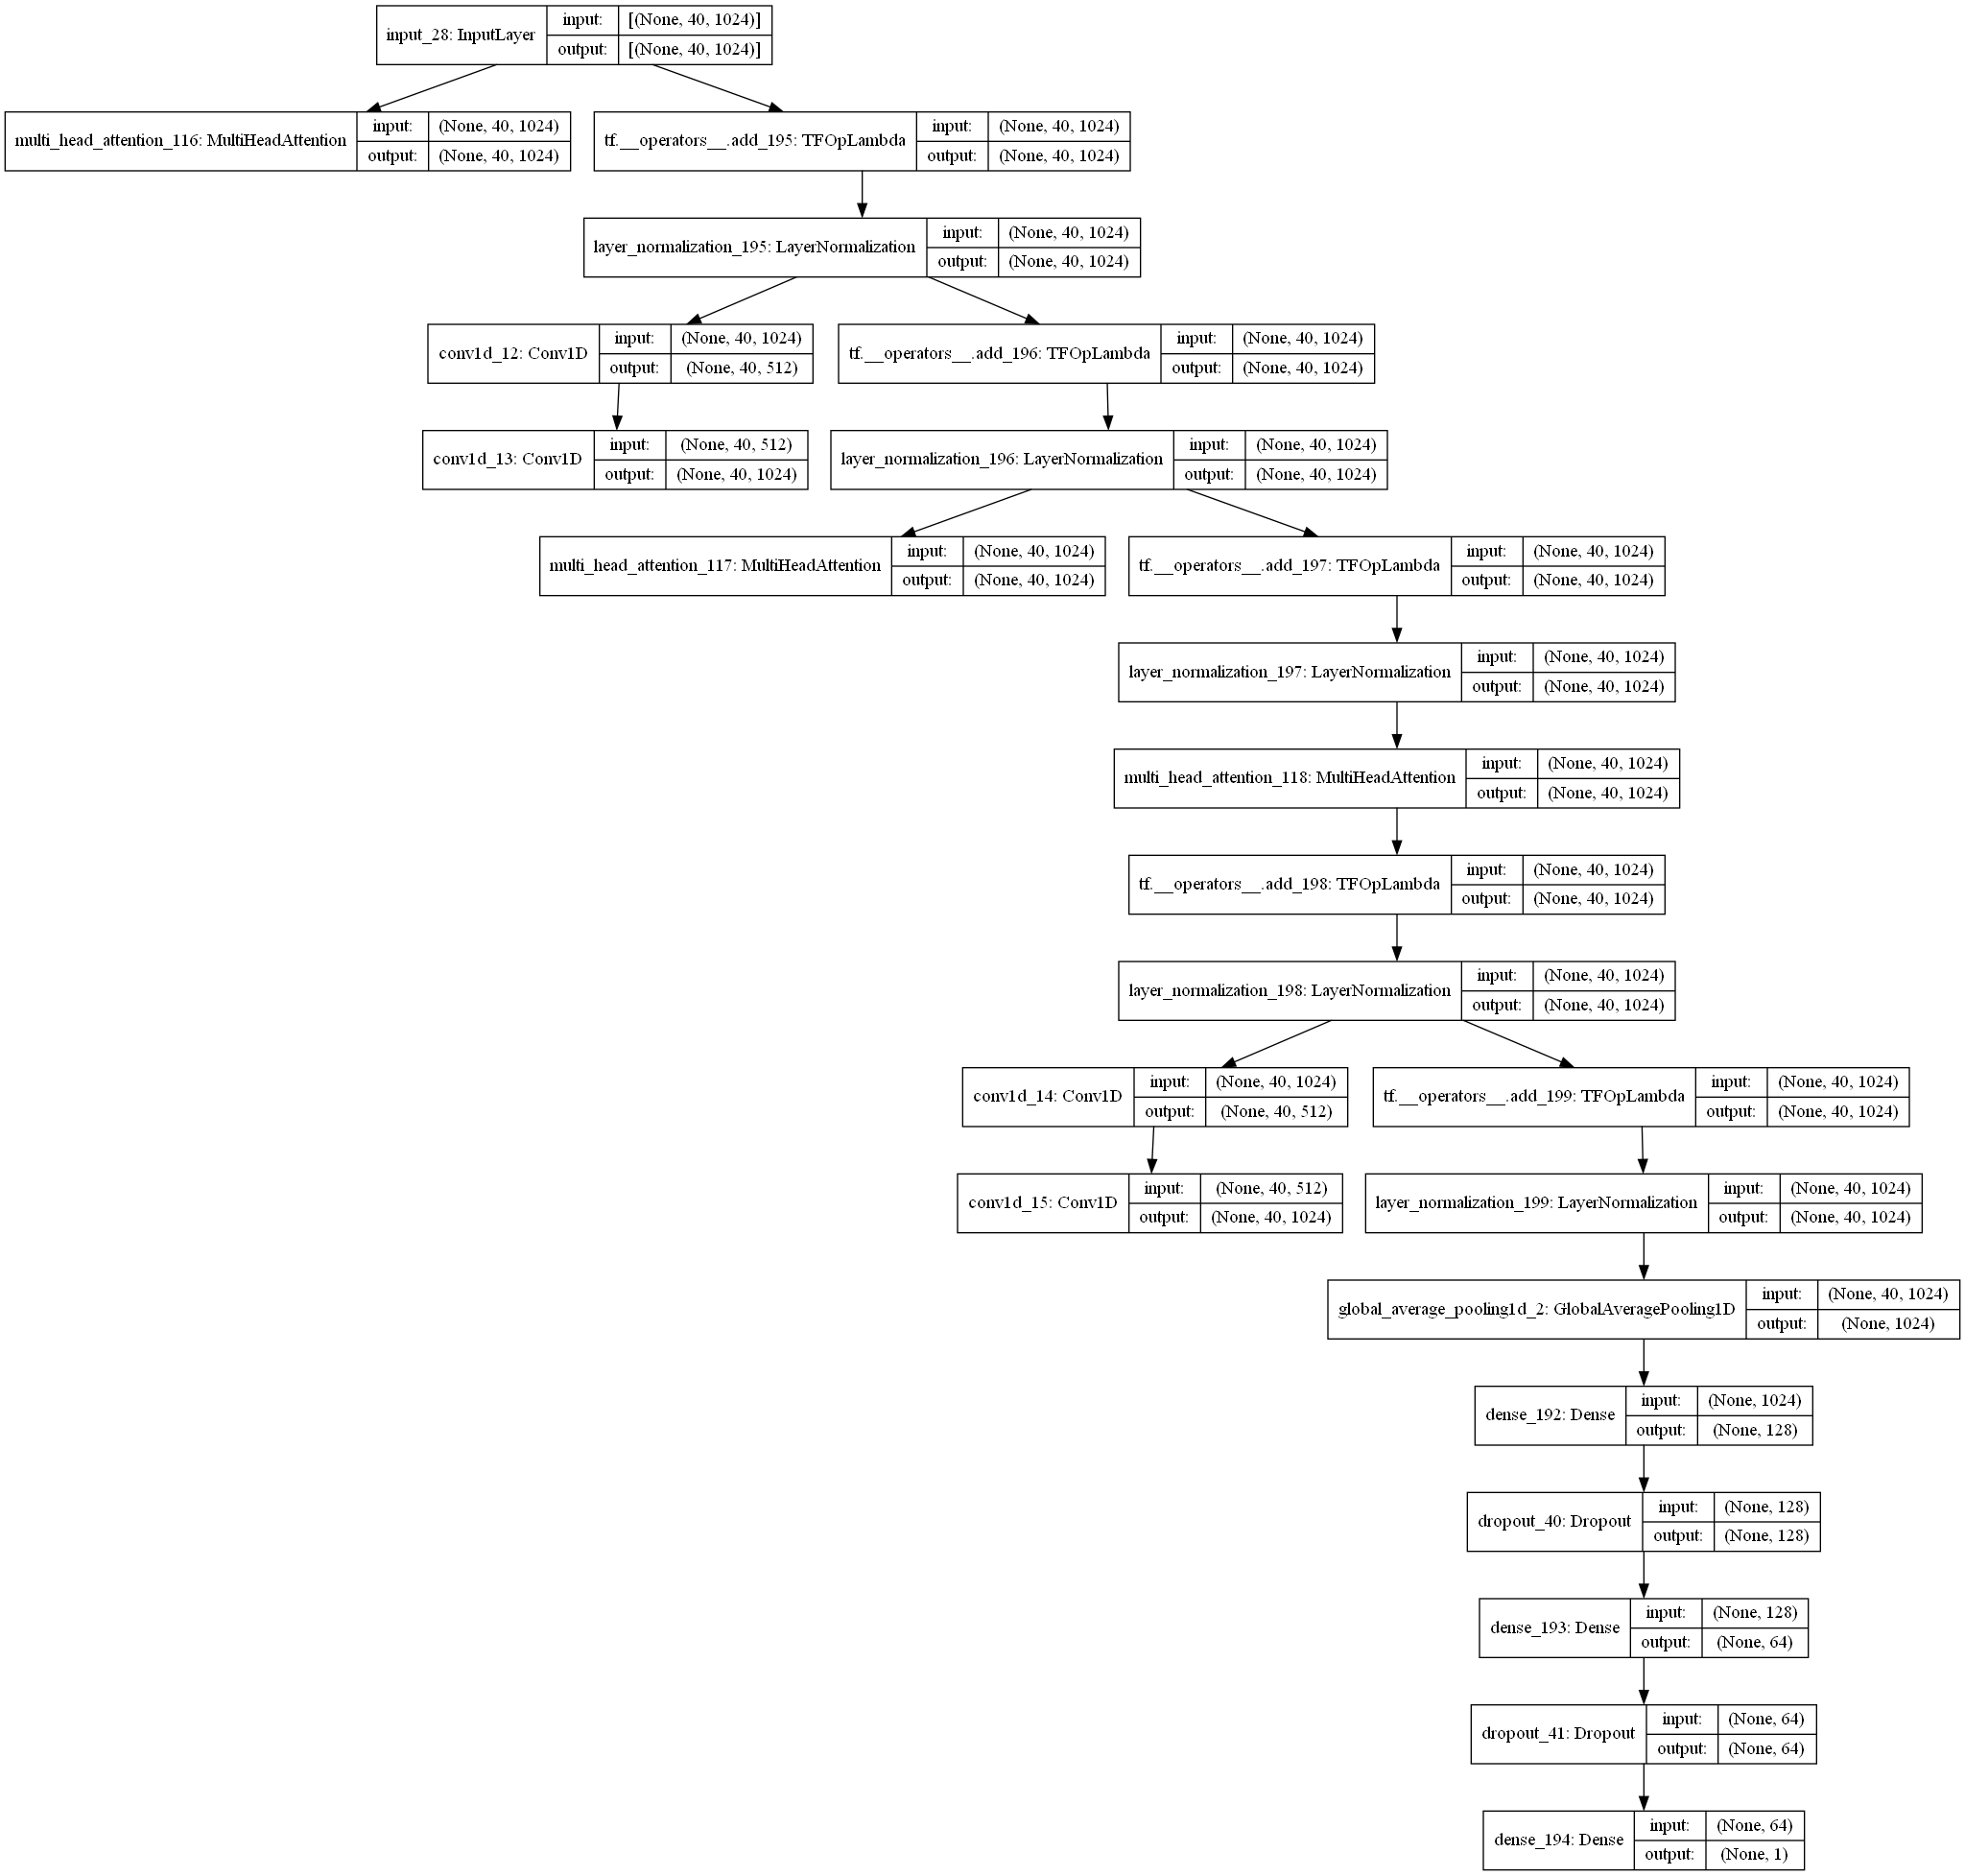

In [105]:
tf.keras.utils.plot_model(EC_Transformer_40, show_shapes=True)

# Load model

In [32]:
# My paper's models
# load model (only with sequence-based features)
EC_bilstm_40 = load_model('model_max_40/EC_bilstm_40.h5')
SA_bilstm_40 = load_model('model_max_40/SA_bilstm_40.h5')
PA_bilstm_40 = load_model('model_max_40/PA_bilstm_40.h5')

EC_CNN_40 = load_model('model_max_40/EC_CNN_40.h5')
SA_CNN_40 = load_model('model_max_40/SA_CNN_40.h5')
PA_CNN_40 = load_model('model_max_40/PA_CNN_40.h5')

T5_EC_bilstm_40 = load_model('model_max_40/T5_EC_bilstm_40.h5')
T5_SA_bilstm_40 = load_model('model_max_40/T5_SA_bilstm_40.h5')
T5_PA_bilstm_40 = load_model('model_max_40/T5_PA_bilstm_40.h5')

T5_EC_CNN_40 = load_model('model_max_40/T5_EC_CNN_40.h5')
T5_SA_CNN_40 = load_model('model_max_40/T5_SA_CNN_40.h5')
T5_PA_CNN_40 = load_model('model_max_40/T5_PA_CNN_40.h5')

EC_Transformer_40 = load_model('model_max_40/EC_Transformer_40.h5')
SA_Transformer_40 = load_model('model_max_40/SA_Transformer_40.h5')
PA_Transformer_40 = load_model('model_max_40/PA_Transformer_40.h5')

EC_MB_40 = load_model('model_max_40/EC_Bi_CNN_40.h5')
SA_MB_40 = load_model('model_max_40/SA_Bi_CNN_40.h5')
PA_MB_40 = load_model('model_max_40/PA_Bi_CNN_40.h5')

# load model (sequenced-based + genome-based features)
T5_Three_Bi_model = load_model('model_max_40/T5_Three_Bi_40.h5')
T5_Three_CNN_model = load_model('model_max_40/T5_Three_CNN_40.h5')
T5_Three_Tf_model = load_model('model_max_40/T5_Three_Tf_40.h5')
T5_Three_MB_model = load_model('model_max_40/T5_Three_MB_40.h5', custom_objects={'r_squared': r_squared})

In [35]:
print('------------SA------------')
print('BiLSTM: Sequence encoding')
SA_bilstm_pred = SA_bilstm_40.predict(SA_X_test)
SA_bilstm_PCC = evaluate(SA_bilstm_pred.reshape(-1), SA_test['NEW-CONCENTRATION'])
print('BiLSTM: T5XL')
T5_SA_bilstm_pred = T5_SA_bilstm_40.predict(T5XL_SA_X_test)
T5_SA_bilstm_PCC = evaluate(T5_SA_bilstm_pred.reshape(-1), SA_test['NEW-CONCENTRATION'])
print('CNN: Sequence encoding')
SA_CNN_pred = SA_CNN_40.predict(SA_X_test.reshape(SA_X_test.shape[0],SA_X_test.shape[1],SA_X_test.shape[2],-1))
SA_CNN_PCC = evaluate(SA_CNN_pred.reshape(-1), SA_test['NEW-CONCENTRATION'])
print('CNN: T5XL')
T5_SA_CNN_pred = T5_SA_CNN_40.predict(T5XL_SA_X_test.reshape(T5XL_SA_X_test.shape[0],T5XL_SA_X_test.shape[1],T5XL_SA_X_test.shape[2],-1))
T5_SA_CNN_PCC = evaluate(T5_SA_CNN_pred.reshape(-1), SA_test['NEW-CONCENTRATION'])
print('Transformer: T5XL')
SA_Transformer_pred = SA_Transformer_40.predict(T5XL_SA_X_test)
SA_Transformer_PCC = evaluate(SA_Transformer_pred.reshape(-1), SA_test['NEW-CONCENTRATION'])
print('Multi-Branch: T5XL')
SA_MB_pred = SA_MB_40.predict([SA_X1,SA_X2])
SA_MB_PCC = evaluate(SA_MB_pred.reshape(-1), SA_test['NEW-CONCENTRATION'])
print('------------EC------------')
print('BiLSTM: Sequence encoding')
EC_bilstm_pred = EC_bilstm_40.predict(EC_X_test)
EC_bilstm_PCC = evaluate(EC_bilstm_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])
print('BiLSTM: T5XL')
T5_EC_bilstm_pred = T5_EC_bilstm_40.predict(T5XL_EC_X_test)
T5_EC_bilstm_PCC = evaluate(T5_EC_bilstm_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])
print('CNN: Sequence encoding')
EC_CNN_pred = EC_CNN_40.predict(EC_X_test.reshape(EC_X_test.shape[0],EC_X_test.shape[1],EC_X_test.shape[2],-1))
EC_CNN_PCC = evaluate(EC_CNN_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])
print('CNN: T5XL')
T5_EC_CNN_pred = T5_EC_CNN_40.predict(T5XL_EC_X_test.reshape(T5XL_EC_X_test.shape[0],T5XL_EC_X_test.shape[1],T5XL_EC_X_test.shape[2],-1))
T5_EC_CNN_PCC = evaluate(T5_EC_CNN_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])
print('Transformer: T5XL')
EC_Transformer_pred = EC_Transformer_40.predict(T5XL_EC_X_test)
EC_Transformer_PCC = evaluate(EC_Transformer_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])
print('Multi-Branch: T5XL')
EC_MB_pred = EC_MB_40.predict([EC_X1,EC_X2])
EC_MB_PCC = evaluate(EC_MB_pred.reshape(-1), EC_test['NEW-CONCENTRATION'])
print('------------PA------------')
print('BiLSTM: Sequence encoding')
PA_bilstm_pred = PA_bilstm_40.predict(PA_X_test)
PA_bilstm_PCC = evaluate(PA_bilstm_pred.reshape(-1), PA_test['NEW-CONCENTRATION'])
print('BiLSTM: T5XL')
T5_PA_bilstm_pred = T5_PA_bilstm_40.predict(T5XL_PA_X_test)
T5_PA_bilstm_PCC = evaluate(T5_PA_bilstm_pred.reshape(-1), PA_test['NEW-CONCENTRATION'])
print('CNN: Sequence encoding')
PA_CNN_pred = PA_CNN_40.predict(PA_X_test.reshape(PA_X_test.shape[0],PA_X_test.shape[1],PA_X_test.shape[2],-1))
PA_CNN_PCC = evaluate(PA_CNN_pred.reshape(-1), PA_test['NEW-CONCENTRATION'])
print('CNN: T5XL')
T5_PA_CNN_pred = T5_PA_CNN_40.predict(T5XL_PA_X_test.reshape(T5XL_PA_X_test.shape[0],T5XL_PA_X_test.shape[1],T5XL_PA_X_test.shape[2],-1))
T5_PA_CNN_PCC = evaluate(T5_PA_CNN_pred.reshape(-1), PA_test['NEW-CONCENTRATION'])
print('Transformer: T5XL')
PA_Transformer_pred = PA_Transformer_40.predict(T5XL_PA_X_test)
PA_Transformer_PCC = evaluate(PA_Transformer_pred.reshape(-1), PA_test['NEW-CONCENTRATION'])
print('Multi-Branch: T5XL')
PA_MB_pred = PA_MB_40.predict([PA_X1,PA_X2])
PA_MB_PCC = evaluate(PA_MB_pred.reshape(-1), PA_test['NEW-CONCENTRATION'])


------------SA------------
BiLSTM: Sequence encoding
Model Performance
MSE: 0.507.
MAE = 0.550.
R2 = 0.204.
PCC = 0.461.
BiLSTM: T5XL
Model Performance
MSE: 0.359.
MAE = 0.457.
R2 = 0.437.
PCC = 0.665.
CNN: Sequence encoding
Model Performance
MSE: 0.410.
MAE = 0.511.
R2 = 0.356.
PCC = 0.613.
CNN: T5XL
Model Performance
MSE: 0.387.
MAE = 0.481.
R2 = 0.393.
PCC = 0.628.
Transformer: T5XL
Model Performance
MSE: 0.507.
MAE = 0.538.
R2 = 0.205.
PCC = 0.472.
Multi-Branch: T5XL
Model Performance
MSE: 0.369.
MAE = 0.453.
R2 = 0.421.
PCC = 0.661.
------------EC------------
BiLSTM: Sequence encoding
Model Performance
MSE: 0.394.
MAE = 0.498.
R2 = 0.303.
PCC = 0.578.
BiLSTM: T5XL
Model Performance
MSE: 0.283.
MAE = 0.394.
R2 = 0.501.
PCC = 0.709.
CNN: Sequence encoding
Model Performance
MSE: 0.291.
MAE = 0.409.
R2 = 0.486.
PCC = 0.698.
CNN: T5XL
Model Performance
MSE: 0.256.
MAE = 0.384.
R2 = 0.548.
PCC = 0.740.
Transformer: T5XL
Model Performance
MSE: 0.293.
MAE = 0.410.
R2 = 0.482.
PCC = 0.706.

In [36]:
# Three Concat
SA_pred = pd.DataFrame(columns ={'CNN','BILSTM','MB'})
EC_pred = pd.DataFrame(columns ={'CNN','BILSTM','MB'})
PA_pred = pd.DataFrame(columns ={'CNN','BILSTM','MB'})

X_test = {'SA_X_test':T5XL_SA_X_test_GS,
          'EC_X_test':T5XL_EC_X_test_GS,
          'PA_X_test':T5XL_PA_X_test_GS
}
y_test = {'SA_y_test':SA_test['NEW-CONCENTRATION'],
          'EC_y_test':EC_test['NEW-CONCENTRATION'],
          'PA_y_test':PA_test['NEW-CONCENTRATION']
}
pred = {'SA_pred':SA_pred,
        'EC_pred':EC_pred,
        'PA_pred':PA_pred}

print('T5_Three_CNN')
for X,y,p in zip(X_test,y_test,pred):
    print(X,y)
    CNN_pred = T5_Three_CNN_model.predict([X_test.get(X)[:,:40,:],X_test.get(X)[:,40,:][:,:84]])
    CNN_PCC = evaluate(CNN_pred.reshape(-1),y_test.get(y))
    pred.get(p)['CNN'] = CNN_pred.reshape(-1).tolist()
print('---------------------------------------')
print('T5_Three_Bi')
for X,y,p in zip(X_test,y_test,pred):
    print(X,y)
    Bi_pred = T5_Three_Bi_model.predict([X_test.get(X)[:,:40,:],X_test.get(X)[:,40,:][:,:84]])
    Bi_PCC = evaluate(Bi_pred.reshape(-1),y_test.get(y))
    pred.get(p)['BILSTM'] = Bi_pred.reshape(-1).tolist()
print('---------------------------------------')
print('T5_Three_Transformer')
for X,y in zip(X_test,y_test):
    print(X,y)
    Tf_pred = T5_Three_Tf_model.predict([X_test.get(X)[:,:40,:],X_test.get(X)[:,40,:][:,:84]])
    Tf_PCC = evaluate(Tf_pred.reshape(-1),y_test.get(y))
print('---------------------------------------')    
print('T5_Three_MB')
for X,y,p in zip(X_test,y_test,pred):
    print(X,y)
    MB_40_pred = T5_Three_MB_model.predict([X_test.get(X)[:,:40,:],X_test.get(X)[:,:40,:],X_test.get(X)[:,40,:][:,:84]])
    MB_40_PCC = evaluate(MB_40_pred.reshape(-1),y_test.get(y))
    pred.get(p)['MB'] = MB_40_pred.reshape(-1).tolist()


T5_Three_CNN
SA_X_test SA_y_test
Model Performance
MSE: 0.331.
MAE = 0.432.
R2 = 0.481.
PCC = 0.697.
EC_X_test EC_y_test
Model Performance
MSE: 0.271.
MAE = 0.386.
R2 = 0.521.
PCC = 0.732.
PA_X_test PA_y_test
Model Performance
MSE: 0.248.
MAE = 0.375.
R2 = 0.564.
PCC = 0.756.
---------------------------------------
T5_Three_Bi
SA_X_test SA_y_test
Model Performance
MSE: 0.322.
MAE = 0.423.
R2 = 0.495.
PCC = 0.720.
EC_X_test EC_y_test
Model Performance
MSE: 0.235.
MAE = 0.353.
R2 = 0.584.
PCC = 0.772.
PA_X_test PA_y_test
Model Performance
MSE: 0.230.
MAE = 0.349.
R2 = 0.594.
PCC = 0.785.
---------------------------------------
T5_Three_Transformer
SA_X_test SA_y_test
Model Performance
MSE: 0.394.
MAE = 0.493.
R2 = 0.382.
PCC = 0.622.
EC_X_test EC_y_test
Model Performance
MSE: 0.313.
MAE = 0.424.
R2 = 0.447.
PCC = 0.680.
PA_X_test PA_y_test
Model Performance
MSE: 0.330.
MAE = 0.446.
R2 = 0.419.
PCC = 0.698.
---------------------------------------
T5_Three_MB
SA_X_test SA_y_test
Model Perf